<a href="https://colab.research.google.com/github/Matheus-P/GANs-for-image-Denoising/blob/main/GANs_for_image_Denoising.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive

drive.mount('/content/drive')

Mounted at /content/drive


# Imports and definitions


In [ ]:
%matplotlib inline
import argparse
import os
import random
import torch
import torch.nn as nn
import torch.nn.parallel
import torch.backends.cudnn as cudnn
import torch.optim as optim
import torch.utils.data
import torchvision.datasets as dset
import torchvision.transforms as transforms
import torchvision.utils as vutils
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
from IPython.display import HTML
from PIL import Image
from math import exp
from torch.autograd import Variable
import torch.nn.functional as F

# Set random seed for reproducibility
manualSeed = 42
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)

Random Seed:  42


In [ ]:
#! mkdir /content/drive/MyDrive/Colab\ Notebooks/PDI/data/celeba

In [ ]:
#! unzip /content/drive/MyDrive/Colab\ Notebooks/PDI/Copy\ of\ img_align_celeba.zip -d /content/drive/MyDrive/Colab\ Notebooks/PDI/data/celeba

In [ ]:
# Root directory for dataset
dataroot_test = "/content/drive/MyDrive/GOPRO_Large/test/"
dataroot_train = "/content/drive/MyDrive/GOPRO_Large/train/"
save_path = "/content/drive/MyDrive/PDImodel"

# Number of workers for dataloader
workers = 2

# Batch size during training
batch_size = 4

# Spatial size of training images. All images will be resized to this
# size using a transform
image_size = 360

# Number of training epochs
num_epochs = 5

In [ ]:
# Decide which device we want to run on
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Dataset

In [ ]:
class MyDataset(torch.utils.data.Dataset):
  def __init__(self, folder):
    self.folder = folder
    self.transform = transforms.Compose([
                     transforms.Resize(image_size),
                     transforms.ToTensor()
                     ])
    self.blur_folder = self.folder+'/blur/'
    self.sharp_folder = self.folder+'/sharp/'
    self.blur_files = os.listdir(self.blur_folder)
    self.sharp_files = os.listdir(self.sharp_folder)

  def __len__(self):
    return len(self.sharp_files)

  def __getitem__(self, index):
    return (
        self.transform(Image.open(self.blur_folder+self.blur_files[index])),
        self.transform(Image.open(self.sharp_folder+self.sharp_files[index]))
    )

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
dataset = MyDataset(folder = dataroot_train)
# Create the dataloader
dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some training images
#batch = next(iter(dataloader))
#plt.figure(figsize=(2,1))
#plt.axis("off")
#plt.title("Training Images")
#plt.imshow(np.transpose(vutils.make_grid(batch[0].to(device)[:2]).cpu(),(1,2,0)))
#plt.imshow(np.transpose(vutils.make_grid(batch[1].to(device)[:2]).cpu(),(1,2,0)))

In [ ]:
#dataset[0][0].size()

In [ ]:
#plt.imshow(np.transpose(dataset[0][0].cpu(),(1,2,0)))

In [ ]:
#plt.imshow(np.transpose(dataset[0][1].cpu(),(1,2,0)))

# Model

In [ ]:
# AutoEncoder Generator Code

class AutoEncoderGenerator(nn.Module):
    def __init__(self):
        super(AutoEncoderGenerator, self).__init__()
        self.layers = nn.Sequential(
            # input is 3 x 360 x 360 image
            nn.Conv2d( 3 , 64 , 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 32 x 180 x 180 features 
            nn.Conv2d( 64 , 32 , 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 16 x 90 x 90 features 
            nn.Conv2d( 32 , 16 , 4, 2, 1),
            nn.BatchNorm2d(16),
            nn.ReLU(inplace=True),
            
            # 16 x 45 x 45 features 
            nn.ConvTranspose2d( 16, 32, 4, 2, 1),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            # 16 x 90 x 90 features 
            nn.ConvTranspose2d( 32, 64, 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 16 x 180 x 180 features 
            nn.ConvTranspose2d( 64, 3, 4, 2, 1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
            # 3 x 360 x 360 image
        )

    def forward(self, input):
        return self.layers(input)

In [ ]:
# CNN Generator Code

class CNNGenerator(nn.Module):
    def __init__(self):
        super(CNNGenerator, self).__init__()
        self.layers = nn.Sequential(
            # input is 3 x 360 x 360 image
            nn.Conv2d( 3 , 64 , 4, 2, 1),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            # 64 x 180 x 180 features
            nn.ConvTranspose2d( 64, 128, 4, 2, 1),
            nn.BatchNorm2d(128),
            nn.ReLU(inplace=True),
            # 64 x 360 x 360 features
            nn.Conv2d( 128 , 256 , 4, 2, 1),
            nn.BatchNorm2d(256),
            nn.ReLU(inplace=True),
            # 64 x 180 x 180 features
            nn.ConvTranspose2d( 256, 512, 4, 2, 1),
            nn.BatchNorm2d(512),
            nn.ReLU(inplace=True),
            # 64 x 360 x 360 features
            nn.Conv2d( 512 , 1024 , 4, 2, 1),
            nn.BatchNorm2d(1024),
            nn.ReLU(inplace=True),
            # 64 x 180 x 180 features
            nn.ConvTranspose2d( 1024, 3, 4, 2, 1),
            nn.BatchNorm2d(3),
            nn.ReLU(inplace=True)
            # 3 x 360 x 360 image
        )

    def forward(self, input):
        return self.layers(input)

In [ ]:
# Discriminator Code

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.layers = nn.Sequential(
            # PatchGan Discriminator
            nn.Conv2d(6, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(64, 128, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(128, 256, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1)),
            nn.BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(256, 512, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1)),
            nn.BatchNorm2d(512, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True),
            nn.LeakyReLU(negative_slope=0.2, inplace=True),

            nn.Conv2d(512, 1, kernel_size=(4, 4), stride=(1, 1), padding=(1, 1))
        )

    def forward(self, input):
        return self.layers(input)

In [ ]:
# Complete Model

class GAN(nn.Module):
  def __init__(self, gen_type):
    super(GAN, self).__init__()
    # Define labels
    self.register_buffer('real_label', torch.tensor(1.0))
    self.register_buffer('fake_label', torch.tensor(0.0))

    # Setup generator and discriminator
    if gen_type == 'CNN':
      self.generator = CNNGenerator().to(device)
    if gen_type == 'AutoEncoder':
      self.generator = AutoEncoderGenerator().to(device)

    self.discriminator = Discriminator().to(device)
    
    # Setup losses
    self.criterionGAN = nn.BCEWithLogitsLoss().to(device)
    self.criterionL1 = nn.L1Loss().to(device)
    
    # Setup Adam optimizers for both G and D
    self.optimizer_G = optim.Adam(self.generator.parameters(), 
                                 lr = 0.0002, betas = (0.5, 0.999))
    self.optimizer_D = optim.Adam(self.discriminator.parameters(), 
                                 lr = 0.0002, betas = (0.5, 0.999))

  def set_input(self,input,target):
    self.real_input = input.to(device)
    self.real_target = target.to(device)

  def forward(self):
    self.fake_target = self.generator(self.real_input)

  def backward_D(self):
    # Test the generator on Generated image; stop backprop to generator
    fake_input_target = torch.cat((self.real_input, self.fake_target), 1)
    fake_pred = self.discriminator(fake_input_target.detach())
    self.loss_D_fake = self.criterionGAN(fake_pred,
                                         self.fake_label.expand_as(fake_pred).to(device))
    # Real image
    real_input_target = torch.cat((self.real_input, self.real_target), 1)
    real_pred = self.discriminator(real_input_target)
    self.loss_D_real = self.criterionGAN(real_pred,
                                         self.real_label.expand_as(real_pred).to(device))
    # Combine loss and backpropagate
    self.loss_D = (self.loss_D_fake + self.loss_D_real)*0.5
    self.loss_D.backward()
  
  def backward_G(self):
    # Try to fool the discriminator using real labels on generated image
    fake_input_target = torch.cat((self.real_input, self.fake_target), 1)
    fake_pred = self.discriminator(fake_input_target)
    self.loss_G_GAN = self.criterionGAN(fake_pred,
                                        self.real_label.expand_as(fake_pred).to(device))
    # Try to make generated image = real image; larger weight than GAN Loss
    self.loss_G_L1 = self.criterionL1(self.fake_target, self.real_target)*100.0
    # Combine loss and backpropagate
    self.loss_G = self.loss_G_GAN + self.loss_G_L1
    self.loss_G.backward()

  def optimize(self):
    self.forward()                   # compute fake images: G(input)

    # update D   -------------------------------------------------------

    # enable backprop for D
    for param in self.discriminator.parameters():
      param.requires_grad = True
    self.optimizer_D.zero_grad()     # set D's gradients to zero
    self.backward_D()                # calculate gradients for D
    self.optimizer_D.step()          # update D's weights

    # update G   -------------------------------------------------------

    # D requires no gradients when optimizing G
    for param in self.discriminator.parameters():
      param.requires_grad = False
    self.optimizer_G.zero_grad()        # set G's gradients to zero
    self.backward_G()                   # calculate graidents for G
    self.optimizer_G.step()             # udpate G's weights

In [ ]:
AEGAN = GAN('AutoEncoder')
CNNGAN = GAN('CNN')

# Training

In [ ]:
# Training Loop
def train(model, use_checkpoint = False, iter = 0):
  # Lists to keep track of progress
  img_list = []
  losses = []
  iters = 0

  if use_checkpoint:
    losses = load_model(model, iter)

  print("Starting Training Loop...")
  # For each epoch
  for epoch in range(num_epochs):
    # For each batch in the dataloader
    for i, (x,y) in enumerate(dataloader, 0):
      if use_checkpoint and iters < iter:
        iters += 1
        continue
     
      model.set_input(x,y)
      model.optimize()

      # Output training stats
      if i % 50 == 0:
        print('[%d/%d][%d/%d]\tLoss_D: %.4f\tLoss_G: %.4f' % (epoch, 
              num_epochs, i, len(dataloader), model.loss_D.item(), 
              model.loss_G.item()))

      # Save Losses for plotting later
      losses.append((model.loss_D.item(),model.loss_G.item()))

      iters += 1

      # save model
      if iters % 5 == 0:
        if type(model.generator) is AutoEncoderGenerator:
          save_model('AutoEncoder', iters, losses)
        elif type(model.generator) is CNNGenerator:
          save_model('CNN', iters, losses)
        img_list.append(model.fake_target)

  return losses, img_list

In [ ]:
def save_model(type_gan, iter, loss):
  if type_gan == 'AutoEncoder':
    f = os.path.join(save_path, 'AEGAN_{}iter.ckpt'.format(iter))
    f_loss = os.path.join(save_path, 'AEGAN_loss_{}iter.npy'.format(iter))
    torch.save(AEGAN.state_dict(), f)
  elif type_gan == 'CNN':
    f = os.path.join(save_path, 'CNNGAN_{}iter.ckpt'.format(iter))
    f_loss = os.path.join(save_path, 'CNNGAN_loss_{}iter.npy'.format(iter))
    torch.save(CNNGAN.state_dict(), f)
  if loss:
    np.save(f_loss, np.array(loss))

def load_model(GAN, iter):
  if type(GAN.generator) is AutoEncoderGenerator:
    gantype = 'AE'
  elif type(GAN.generator) is CNNGenerator:
    gantype = 'CNN'
  f = os.path.join(save_path, '{}GAN_{}iter.ckpt'.format(gantype,iter))
  checkpoint = torch.load(f,map_location=torch.device(device))
  GAN.load_state_dict(checkpoint)
  f_loss = os.path.join(save_path, '{}GAN_loss_{}iter.npy'.format(gantype,iter))
  losses = np.load(f_loss)
  return losses.tolist()

In [ ]:
AE_losses, AE_list = train(AEGAN)

Starting Training Loop...
[0/5][0/132]	Loss_D: 0.6289	Loss_G: 37.9049
[0/5][50/132]	Loss_D: 0.2872	Loss_G: 16.2729
[0/5][100/132]	Loss_D: 0.1481	Loss_G: 15.8262
[1/5][0/132]	Loss_D: 0.0357	Loss_G: 17.1154
[1/5][50/132]	Loss_D: 0.0820	Loss_G: 16.8433
[1/5][100/132]	Loss_D: 0.0186	Loss_G: 14.3741
[2/5][0/132]	Loss_D: 0.0103	Loss_G: 17.4965
[2/5][50/132]	Loss_D: 0.0073	Loss_G: 17.9026
[2/5][100/132]	Loss_D: 1.4906	Loss_G: 11.5190
[3/5][0/132]	Loss_D: 0.0720	Loss_G: 19.7754
[3/5][50/132]	Loss_D: 0.0219	Loss_G: 13.7023
[3/5][100/132]	Loss_D: 0.0082	Loss_G: 14.9100
[4/5][0/132]	Loss_D: 0.0162	Loss_G: 19.2841
[4/5][50/132]	Loss_D: 0.0148	Loss_G: 19.3688
[4/5][100/132]	Loss_D: 0.0133	Loss_G: 15.1616


In [ ]:
CNN_losses, CNN_list = train(CNNGAN)

Starting Training Loop...
[0/5][0/526]	Loss_D: 0.7166	Loss_G: 45.6318
[0/5][50/526]	Loss_D: 0.4715	Loss_G: 8.3922
[0/5][100/526]	Loss_D: 0.3185	Loss_G: 26.0387
[0/5][150/526]	Loss_D: 0.0230	Loss_G: 14.5712
[0/5][200/526]	Loss_D: 0.0107	Loss_G: 24.2145
[0/5][250/526]	Loss_D: 0.5095	Loss_G: 14.9758
[0/5][300/526]	Loss_D: 0.0293	Loss_G: 10.2143
[0/5][350/526]	Loss_D: 0.0394	Loss_G: 14.5754


RuntimeError: ignored

In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=525)

Starting Training Loop...
[1/5][0/526]	Loss_D: 0.0026	Loss_G: 15.1105
[1/5][50/526]	Loss_D: 0.0377	Loss_G: 11.4358
[1/5][100/526]	Loss_D: 0.0141	Loss_G: 20.6905


RuntimeError: ignored

In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=660)

Starting Training Loop...
[1/5][150/526]	Loss_D: 0.6746	Loss_G: 14.7876
[1/5][200/526]	Loss_D: 0.0075	Loss_G: 17.6025
[1/5][250/526]	Loss_D: 0.0048	Loss_G: 13.3185
[1/5][300/526]	Loss_D: 0.0013	Loss_G: 14.2765
[1/5][350/526]	Loss_D: 0.0018	Loss_G: 27.2001
[1/5][400/526]	Loss_D: 0.0049	Loss_G: 15.2203
[1/5][450/526]	Loss_D: 0.0029	Loss_G: 26.1231
[1/5][500/526]	Loss_D: 0.0015	Loss_G: 14.5723


RuntimeError: ignored

In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=1035)

Starting Training Loop...
[2/5][0/526]	Loss_D: 0.0004	Loss_G: 22.1825
[2/5][50/526]	Loss_D: 0.0001	Loss_G: 18.8302
[2/5][100/526]	Loss_D: 0.1312	Loss_G: 13.5306
[2/5][150/526]	Loss_D: 0.0016	Loss_G: 17.0725
[2/5][200/526]	Loss_D: 0.0009	Loss_G: 14.6928
[2/5][250/526]	Loss_D: 0.0006	Loss_G: 15.1620
[2/5][300/526]	Loss_D: 0.0005	Loss_G: 22.8165
[2/5][350/526]	Loss_D: 0.0004	Loss_G: 22.7380


RuntimeError: ignored

In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=1410)

Starting Training Loop...
[2/5][400/526]	Loss_D: 0.0001	Loss_G: 18.2719
[2/5][450/526]	Loss_D: 0.0001	Loss_G: 17.5130
[2/5][500/526]	Loss_D: 0.0000	Loss_G: 20.9174
[3/5][0/526]	Loss_D: 0.0000	Loss_G: 18.6179
[3/5][50/526]	Loss_D: 0.0000	Loss_G: 17.7196
[3/5][100/526]	Loss_D: 0.0000	Loss_G: 22.0660
[3/5][150/526]	Loss_D: 0.0000	Loss_G: 19.8755
[3/5][200/526]	Loss_D: 0.0000	Loss_G: 19.8658


RuntimeError: ignored

In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=1780)

Starting Training Loop...
[3/5][250/526]	Loss_D: 0.0000	Loss_G: 18.2010
[3/5][300/526]	Loss_D: 0.0000	Loss_G: 21.1248
[3/5][350/526]	Loss_D: 0.0006	Loss_G: 13.7500
[3/5][400/526]	Loss_D: 0.0011	Loss_G: 21.9173


In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=1980)

Starting Training Loop...
[3/5][450/526]	Loss_D: 0.0000	Loss_G: 18.7051


KeyboardInterrupt: ignored

In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=2030)

Starting Training Loop...
[3/5][500/526]	Loss_D: 0.0017	Loss_G: 20.4092
[4/5][0/526]	Loss_D: 0.0035	Loss_G: 29.5244
[4/5][50/526]	Loss_D: 0.0556	Loss_G: 9.1520
[4/5][100/526]	Loss_D: 0.0356	Loss_G: 11.3307
[4/5][150/526]	Loss_D: 0.6631	Loss_G: 9.3755
[4/5][200/526]	Loss_D: 0.0167	Loss_G: 14.9183
[4/5][250/526]	Loss_D: 0.2104	Loss_G: 15.6038


RuntimeError: ignored

In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=2400)

Starting Training Loop...
[4/5][300/526]	Loss_D: 0.4160	Loss_G: 13.5110
[4/5][350/526]	Loss_D: 0.0416	Loss_G: 17.5278
[4/5][400/526]	Loss_D: 0.0311	Loss_G: 17.2167
[4/5][450/526]	Loss_D: 0.3515	Loss_G: 9.9028
[4/5][500/526]	Loss_D: 0.0373	Loss_G: 10.4672


In [ ]:
CNN_losses, CNN_list = train(CNNGAN,use_checkpoint=True,iter=2625)

Starting Training Loop...


# Testing

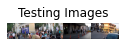

In [ ]:
# We can use an image folder dataset the way we have it setup.
# Create the dataset
test_dataset = MyDataset(folder=dataroot_test)
# Create the dataloader
test_dataloader = torch.utils.data.DataLoader(dataset, batch_size=batch_size,
                                         shuffle=True, num_workers=workers)

# Plot some testing images
real_batch = next(iter(dataloader))
plt.figure(figsize=(2,2))
plt.axis("off")
plt.title("Testing Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:4], padding=2, normalize=True).cpu(),(1,2,0)))

In [ ]:
def test(type_gan):

    # compute PSNR, SSIM, RMSE
    ori_psnr_avg, ori_ssim_avg, ori_rmse_avg = 0, 0, 0
    pred_psnr_avg, pred_ssim_avg, pred_rmse_avg = 0, 0, 0

    with torch.no_grad():
        for i, (x, y) in enumerate(test_dataloader):
            x = x.to(device)
            y = y.to(device)

            if type_gan == 'AutoEncoder':
              pred = AEGAN.generator(x).detach()
            if type_gan == 'CNN':
              pred = CNNGAN.generator(x).detach()

            data_range = 255

            original_result, pred_result = compute_measure(x, y, pred, data_range)
            ori_psnr_avg += original_result[0]
            ori_ssim_avg += original_result[1]
            ori_rmse_avg += original_result[2]
            pred_psnr_avg += pred_result[0]
            pred_ssim_avg += pred_result[1]
            pred_rmse_avg += pred_result[2]
            
        print('Original\nPSNR avg: {:.4f} \nSSIM avg: {:.4f} \nRMSE avg: {:.4f}'.format(ori_psnr_avg/len(test_dataloader), ori_ssim_avg/len(test_dataloader), ori_rmse_avg/len(test_dataloader)))
        print('After learning\nPSNR avg: {:.4f} \nSSIM avg: {:.4f} \nRMSE avg: {:.4f}'.format(pred_psnr_avg/len(test_dataloader), pred_ssim_avg/len(test_dataloader), pred_rmse_avg/len(test_dataloader)))

In [ ]:
def compute_measure(x, y, pred, data_range):
    original_psnr = compute_PSNR(x, y, data_range)
    original_ssim = compute_SSIM(x, y, data_range)
    original_rmse = compute_RMSE(x, y)
    pred_psnr = compute_PSNR(pred, y, data_range)
    pred_ssim = compute_SSIM(pred, y, data_range)
    pred_rmse = compute_RMSE(pred, y)
    return (original_psnr, original_ssim, original_rmse), (pred_psnr, pred_ssim, pred_rmse)


def compute_MSE(img1, img2):
    return ((img1 - img2) ** 2).mean()


def compute_RMSE(img1, img2):
    if type(img1) == torch.Tensor:
        return torch.sqrt(compute_MSE(img1, img2)).item()
    else:
        return np.sqrt(compute_MSE(img1, img2))


def compute_PSNR(img1, img2, data_range):
    if type(img1) == torch.Tensor:
        mse_ = compute_MSE(img1, img2)
        return 10 * torch.log10((data_range ** 2) / mse_).item()
    else:
        mse_ = compute_MSE(img1, img2)
        return 10 * np.log10((data_range ** 2) / mse_)


def compute_SSIM(img1, img2, data_range, window_size=11, channel=3, size_average=True):
    # referred from https://github.com/Po-Hsun-Su/pytorch-ssim
    if len(img1.size()) == 2:
        shape_ = img1.shape[-1]
        img1 = img1.view(1,1,shape_ ,shape_ )
        img2 = img2.view(1,1,shape_ ,shape_ )
    window = create_window(window_size, channel)
    window = window.type_as(img1)

    mu1 = F.conv2d(img1, window, padding=window_size//2)
    mu2 = F.conv2d(img2, window, padding=window_size//2)
    mu1_sq, mu2_sq = mu1.pow(2), mu2.pow(2)
    mu1_mu2 = mu1*mu2

    sigma1_sq = F.conv2d(img1*img1, window, padding=window_size//2) - mu1_sq
    sigma2_sq = F.conv2d(img2*img2, window, padding=window_size//2) - mu2_sq
    sigma12 = F.conv2d(img1*img2, window, padding=window_size//2) - mu1_mu2

    C1, C2 = (0.01*data_range)**2, (0.03*data_range)**2
    #C1, C2 = 0.01**2, 0.03**2

    ssim_map = ((2*mu1_mu2+C1)*(2*sigma12+C2)) / ((mu1_sq+mu2_sq+C1)*(sigma1_sq+sigma2_sq+C2))
    if size_average:
        return ssim_map.mean().item()
    else:
        return ssim_map.mean(1).mean(1).mean(1).item()


def gaussian(window_size, sigma):
    gauss = torch.Tensor([exp(-(x - window_size // 2) ** 2 / float(2 * sigma ** 2)) for x in range(window_size)])
    return gauss / gauss.sum()


def create_window(window_size, channel):
    _1D_window = gaussian(window_size, 1.5).unsqueeze(1)
    _2D_window = _1D_window.mm(_1D_window.t()).float().unsqueeze(0).unsqueeze(0)
    window = Variable(_2D_window.expand(channel, 3, window_size, window_size).contiguous())
    return window

In [ ]:
test('AutoEncoder')

Original
PSNR avg: 66.7827 
SSIM avg: 0.9907 
RMSE avg: 0.1227
After learning
PSNR avg: 64.4267 
SSIM avg: 0.9860 
RMSE avg: 0.1551


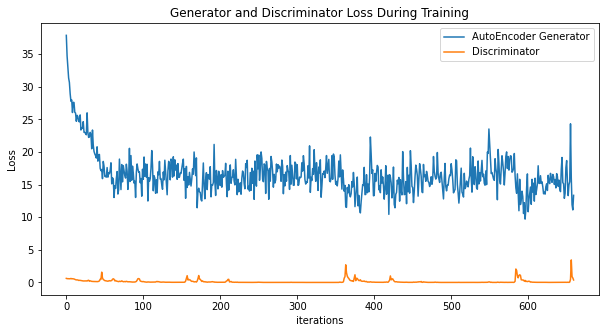

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
tmp = [list(t) for t in zip(*AE_losses)]
g_loss = tmp[1]
d_loss = tmp[0]
plt.plot(g_loss,label="AutoEncoder Generator")
plt.plot(d_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


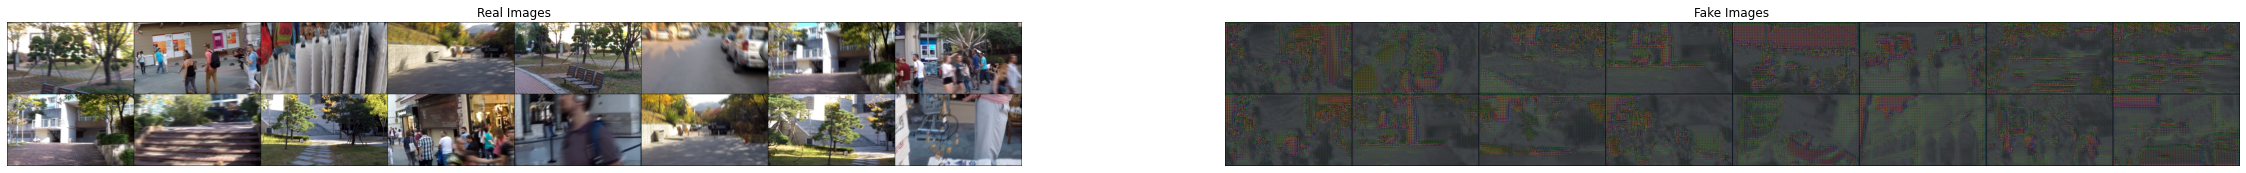

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(40,40))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:16]),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(AE_list[0].cpu()),(1,2,0)))
plt.show()

In [ ]:
test('CNN')

Original
PSNR avg: 69.1411 
SSIM avg: 0.9907 
RMSE avg: 0.1085
After learning
PSNR avg: 64.7310 
SSIM avg: 0.9869 
RMSE avg: 0.1574


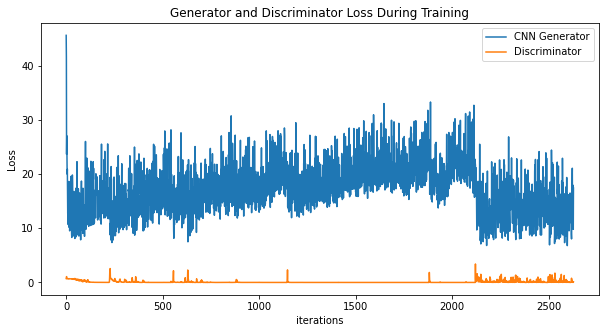

In [ ]:
plt.figure(figsize=(10,5))
plt.title("Generator and Discriminator Loss During Training")
tmp = [list(t) for t in zip(*CNN_losses)]
g_loss = tmp[1]
d_loss = tmp[0]
plt.plot(g_loss,label="CNN Generator")
plt.plot(d_loss,label="Discriminator")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()
plt.show()

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


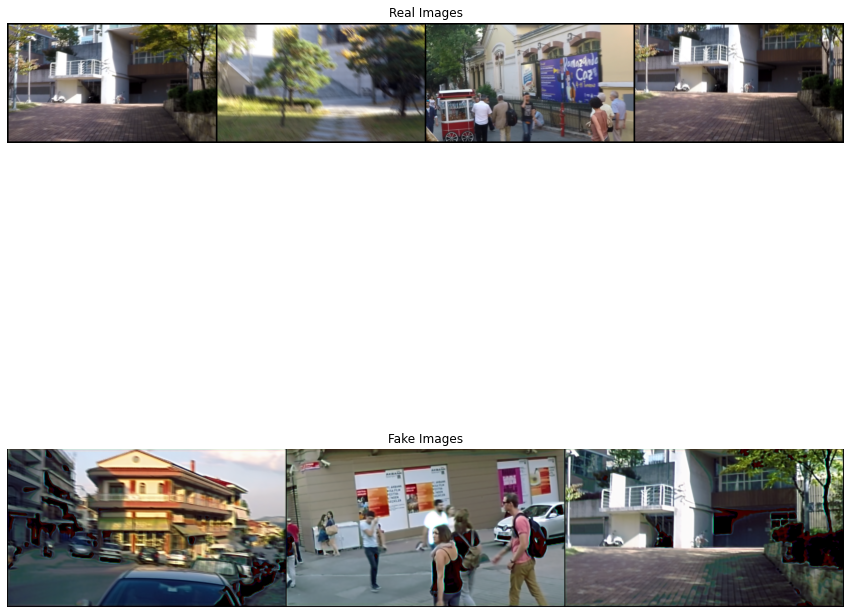

In [ ]:
# Grab a batch of real images from the dataloader
real_batch = next(iter(dataloader))

# Plot the real images
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0].to(device)[:64], padding=5, normalize=True).cpu(),(1,2,0)))

# Plot the fake images from the last epoch
plt.subplot(2,1,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(CNN_list[0].cpu()),(1,2,0)))
plt.show()